# Course 2 Project: ML Pipeline for Feature Engineering

## Instructions

In this project, you'll use data related to microeconomic indicators and historical stock prices to explore the data engineering pipline. You'll get to practice:

* Data ingestion 
* Data cleaning
* Data imputation
* Exploratory data analysis (EDA) through charts and graphs

## Packages

You'll use `pandas` and `matplotlib`, which were covered in the course material, to import, clean, and plot data. They have been installed in this workspace for you. If you're working locally and you installed Jupyter using Anaconda, these packages will already be installed. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

The first step in a data engineering pipeline for machine learning is to ingest the data that will be used. For this project, data is hosted on a public GitHub repo. 

### Your tasks
* Import data from the provided [GitHub repo](https://github.com/udacity/CD13649-Project/tree/main/Project) using `pandas`. For your convenience, the data files (CSVs) are also present in the current workspace at the path **CD13649-Project/Project/**. Here are the data files to import: 
  1. GDP (**GDP.csv**)
  2. Inflation (**inflation_monthly.csv**)
  3. Apple stock prices (**apple_historical_data.csv**)
  4. Microsoft stock prices (**microsoft_historical_data.csv**)
  5. Consumer price index (**consumer_price_index.csv**)



* Verify that the data has been imported correctly into `pandas` dataframes. Use methods like `head()` and `info()`


* You may need to change column names to make them easier to work with


* You may need to cast datetime data to the `datetime` format using `pandas` `to_datetime()` method



In [2]:
# Load historical GDP data
url = 'https://raw.githubusercontent.com/udacity/CD13649-Project/refs/heads/main/Project/GDP.csv'
GDP_df = pd.read_csv(url)


In [3]:
# Check the first few rows of data
GDP_df.head()

,DATE,GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


In [4]:
# Load the historical stock price data for Apple and Microsoft
apple_df = pd.read_csv('http://raw.githubusercontent.com/udacity/CD13649-Project/refs/heads/main/Project/apple_historical_data.csv')
microsoft_df = pd.read_csv('https://raw.githubusercontent.com/udacity/CD13649-Project/refs/heads/main/Project/microsoft_historical_data.csv')


In [5]:
# Check the first few rows of data
apple_df.head()


,Date,Close/Last,Volume,Open,High,Low
0,5/3/2024,$183.38,163224100,$186.65,$187.00,$182.66
1,5/2/2024,$173.03,94214920,$172.51,$173.42,$170.89
2,5/1/2024,$169.30,50383150,$169.58,$172.71,$169.11
3,4/30/2024,$170.33,65934780,$173.33,$174.99,$170.00
4,4/29/2024,$173.50,68169420,$173.37,$176.03,$173.10


In [6]:
microsoft_df.head()

,Date,Close/Last,Volume,Open,High,Low
0,05/03/2024,$406.66,17446720,$402.28,$407.15,$401.86
1,05/02/2024,$397.84,17709360,$397.66,$399.93,$394.6515
2,05/01/2024,$394.94,23562480,$392.61,$401.7199,$390.31
3,04/30/2024,$389.33,28781370,$401.49,$402.16,$389.17
4,04/29/2024,$402.25,19582090,$405.25,$406.32,$399.19


In [7]:
# Use methods like .info() and .describe() to explore the data
apple_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2517 non-null   object
 1   Close/Last  2514 non-null   object
 2   Volume      2517 non-null   int64 
 3   Open        2517 non-null   object
 4   High        2517 non-null   object
 5   Low         2517 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.1+ KB


In [8]:
microsoft_df.describe()

,Volume
count,2.517000e+03
mean,2.953106e+07
std,1.370138e+07
min,7.425603e+06
25%,2.131892e+07
50%,2.639470e+07
75%,3.360003e+07
max,2.025141e+08


## Data preprocessing: Check for missing data and forward fill

Check the Apple historical prices for missing data. Check for missing data in all columns. If there's data missing, use a forward fill to fill in those missing prices. 

In [9]:
# Check for nulls 
apple_df.isnull().sum()


Date          0
Close/Last    3
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [10]:
# Forward fill any missing data
apple_df.fillna(method='ffill', inplace=True)

/tmp/ipykernel_13/3990102583.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  apple_df.fillna(method='ffill', inplace=True)


In [11]:
# Check again for nulls after using forward fill
apple_df.isnull().sum()

Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

## Data preprocessing: Remove special characters and convert to numeric/datetime

The next step in the data engineering process is to standardize and clean up data. In this step, you'll check for odd formatting and special characters that will make it difficult to work with data as numeric or datetime. 

In this step:
* Create a function that takes in a dataframe and a list of columns and removes dollar signs ('$') from those columns
* Convert any columns with date/time data into a `pandas` `datetime` format

In [12]:
def convert_dollar_columns_to_numeric(df, numeric_columns):
    '''
        Removes dollar signs ('$') from a list of columns in a given dataframe AND casts the columns to a numeric datatype.
        Updates dataframe IN PLACE.
        
        Inputs:
            df: dataframe to be operated on
            numeric_columns: columns that should have numeric data but have dollar signs currently
            
        Returns:
            None - changes to the dataframe can be made in place
    '''
    for col in numeric_columns:
        df[col]= df[col].replace({'\$': ''}, regex=True).astype(float)
    
    pass 

In [13]:
# Use convert_dollar_columns_to_numeric() to remove the dollar sign from the Apple and Microsoft datasets
numeric_col = ['Close/Last','Open','High', 'Low']
convert_dollar_columns_to_numeric(apple_df,numeric_col)
convert_dollar_columns_to_numeric(microsoft_df, numeric_col)

In [14]:
# Use pandas's to_datetime() to convert any columns that are in a datetime format
apple_df['Date'] = pd.to_datetime(apple_df['Date'])
microsoft_df['Date'] = pd.to_datetime(microsoft_df['Date'])

In [15]:
# Use .info() and check the type of each column to ensure that the above steps worked
apple_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2517 non-null   datetime64[ns]
 1   Close/Last  2517 non-null   float64       
 2   Volume      2517 non-null   int64         
 3   Open        2517 non-null   float64       
 4   High        2517 non-null   float64       
 5   Low         2517 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.1 KB


In [16]:
microsoft_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2517 non-null   datetime64[ns]
 1   Close/Last  2517 non-null   float64       
 2   Volume      2517 non-null   int64         
 3   Open        2517 non-null   float64       
 4   High        2517 non-null   float64       
 5   Low         2517 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.1 KB


In [17]:
apple_df.drop_duplicates()
microsoft_df.drop_duplicates()

,Date,Close/Last,Volume,Open,High,Low
0,2024-05-03,406.660,17446720,402.28,407.1500,401.8600
1,2024-05-02,397.840,17709360,397.66,399.9300,394.6515
2,2024-05-01,394.940,23562480,392.61,401.7199,390.3100
3,2024-04-30,389.330,28781370,401.49,402.1600,389.1700
4,2024-04-29,402.250,19582090,405.25,406.3200,399.1900
...,...,...,...,...,...,...
2512,2014-05-12,39.970,22761620,39.74,40.0200,39.6500
2513,2014-05-09,39.540,29646100,39.54,39.8500,39.3700
2514,2014-05-08,39.640,32089010,39.34,39.9000,38.9700
2515,2014-05-07,39.425,41731030,39.22,39.5100,38.5100


In [18]:
apple_df.set_index("Date",inplace = True)
apple_df = apple_df.sort_index()
apple_df

,Close/Last,Volume,Open,High,Low
Date,,,,,
2014-05-06,21.23,373872650,21.49,21.59,21.23
2014-05-07,21.15,282128727,21.26,21.33,20.99
2014-05-08,21.00,228973884,21.01,21.23,20.94
2014-05-09,20.91,291068564,20.88,20.94,20.73
2014-05-12,21.17,212736019,20.98,21.20,20.98
...,...,...,...,...,...
2024-04-29,173.50,68169420,173.37,176.03,173.10
2024-04-30,170.33,65934780,173.33,174.99,170.00
2024-05-01,169.30,50383150,169.58,172.71,169.11


In [19]:
microsoft_df.set_index("Date",inplace = True)
microsoft_df = microsoft_df.sort_index()
microsoft_df

,Close/Last,Volume,Open,High,Low
Date,,,,,
2014-05-06,39.060,27105700,39.29,39.3500,38.9500
2014-05-07,39.425,41731030,39.22,39.5100,38.5100
2014-05-08,39.640,32089010,39.34,39.9000,38.9700
2014-05-09,39.540,29646100,39.54,39.8500,39.3700
2014-05-12,39.970,22761620,39.74,40.0200,39.6500
...,...,...,...,...,...
2024-04-29,402.250,19582090,405.25,406.3200,399.1900
2024-04-30,389.330,28781370,401.49,402.1600,389.1700
2024-05-01,394.940,23562480,392.61,401.7199,390.3100


## Data preprocessing: Align datetime data

Data engineering includes changing data with a datetime component if needed so that different time series can be more easily compared or plotted against each other. 

In this step:

* Align the inflation date so that it falls on the last day of the month instead of the first

Helpful hints: 
* Use the `pandas` `offsets` method using `MonthEnd(0)` to set the 'Date' column to month-end

In [20]:
inflation_df = pd.read_csv("https://github.com/udacity/CD13649-Project/blob/main/Project/inflation_monthly.csv?raw=true")

In [21]:
inflation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DATE                  675 non-null    object 
 1   CORESTICKM159SFRBATL  675 non-null    float64
dtypes: float64(1), object(1)
memory usage: 10.7+ KB


In [22]:
inflation_df["DATE"] = pd.to_datetime(inflation_df["DATE"])

In [23]:
inflation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATE                  675 non-null    datetime64[ns]
 1   CORESTICKM159SFRBATL  675 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.7 KB


In [24]:
inflation_df.head()

,DATE,CORESTICKM159SFRBATL
0,1968-01-01,3.651861
1,1968-02-01,3.673819
2,1968-03-01,4.142164
3,1968-04-01,4.155828
4,1968-05-01,4.088245


In [25]:
# Align inflation data so that the date is the month end (e.g. Jan 31, Feb 28/28)
inflation_df["DATE"] =  inflation_df["DATE"]+ pd.offsets.MonthEnd(0)


In [26]:
inflation_df.head()

,DATE,CORESTICKM159SFRBATL
0,1968-01-31,3.651861
1,1968-02-29,3.673819
2,1968-03-31,4.142164
3,1968-04-30,4.155828
4,1968-05-31,4.088245


## Data preprocessing: Upsample, downsample and interpolate data

Inflation data is presented monthly in this dataset. However, for some models, you may need it at a quarterly frequency, and for some models you may need it at a quarterly frequency. 

In this step:
* Create a new quarterly inflation dataframe by downsampling the monthly inflation data to quarterly using the mean (e.g. for quarter 1 in a given year, use the average values from January, February, and March)
* Create a new weekly inflation dataframe by upsampling the monthly inflation data. For this, you'll need to use `resample` and then you'll need to `interpolate` to fill in the missing data at the weekly frequency

Note that you may need to change the index for some of these operations! 

In [27]:
inflation_df.set_index("DATE",inplace = True)

In [28]:
inflation_df.head()

,CORESTICKM159SFRBATL
DATE,
1968-01-31,3.651861
1968-02-29,3.673819
1968-03-31,4.142164
1968-04-30,4.155828
1968-05-31,4.088245


In [29]:
# Upsample and interpolate from monthly to weekly 
inflation_weekly_data = inflation_df.resample('W').interpolate()

In [30]:
inflation_weekly_data.head()

,CORESTICKM159SFRBATL
DATE,
1968-02-04,NaN
1968-02-11,NaN
1968-02-18,NaN
1968-02-25,NaN
1968-03-03,NaN


In [31]:
# Downsample from monthly to quarterly 
inflation_quarter_data = inflation_df.resample('QE').mean()


In [32]:
inflation_quarter_data.head()

,CORESTICKM159SFRBATL
DATE,
1968-03-31,3.822615
1968-06-30,4.263214
1968-09-30,4.882643
1968-12-31,5.429443
1969-03-31,5.873770


## Data preprocessing: Normalize/standardize a feature

Economic time series data often involve variables measured on different scales (e.g., GDP in trillions of dollars, inflation in percentage points). Standardizing these variables (typically by subtracting the mean and dividing by the standard deviation) puts them on a common scale, allowing for meaningful comparisons and analyses.

Your task:
* Standardize the GDP data. You may do this manually by subtracting the mean and dividing by the standard deviation, or you may use a built-in method from a library like `sklearn`'s `StandardScaler`

In [33]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 57.2 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 22.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [34]:
from sklearn.preprocessing import StandardScaler


In [35]:
# Standardize the GDP measure
scaler = StandardScaler()

GDP_df['GDP'] = scaler.fit_transform(GDP_df[['GDP']])


In [36]:
# Check the dataframe to make sure the calculation worked as expected 

GDP_df.head()

,DATE,GDP
0,1947-01-01,-0.935496
1,1947-04-01,-0.935121
2,1947-07-01,-0.934636
3,1947-10-01,-0.933276
4,1948-01-01,-0.932472


## EDA: Plotting a time series of adjusted open vs close price

As part of your EDA, you'll frequently want to plot two time series on the same graph and using the same axis to compare their movements. 

Your task:
* Plot the Apple open and close price time series on the same chart **for the last three months only**. Be sure to use a legend to label each line

**NOTE**: This is a large dataset. If you try to plot the entire series, your graph will be hard to interpret and may take a long time to plot. Be sure to use only the most recent three months of data. 

In [37]:
# Get max date in timeseries
max_date = apple_df.index.max()
date = max_date - pd.DateOffset(months=3)

In [38]:
apple_df = apple_df.sort_index()
apple_df

,Close/Last,Volume,Open,High,Low
Date,,,,,
2014-05-06,21.23,373872650,21.49,21.59,21.23
2014-05-07,21.15,282128727,21.26,21.33,20.99
2014-05-08,21.00,228973884,21.01,21.23,20.94
2014-05-09,20.91,291068564,20.88,20.94,20.73
2014-05-12,21.17,212736019,20.98,21.20,20.98
...,...,...,...,...,...
2024-04-29,173.50,68169420,173.37,176.03,173.10
2024-04-30,170.33,65934780,173.33,174.99,170.00
2024-05-01,169.30,50383150,169.58,172.71,169.11


In [39]:
# Use the max date calculated above to get the last three months of data in the dataset 
apple_last_3_months = apple_df[apple_df.index >= date] 


In [40]:
apple_last_3_months.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2024-02-05,187.68,69668820,188.15,189.25,185.84
2024-02-06,189.30,43490760,186.86,189.31,186.77
2024-02-07,189.41,53438960,190.64,191.05,188.61
2024-02-08,188.32,40962050,189.39,189.54,187.35
2024-02-09,188.85,45155220,188.65,189.99,188.00


In [41]:
apple_last_3_months= apple_last_3_months.sort_index()

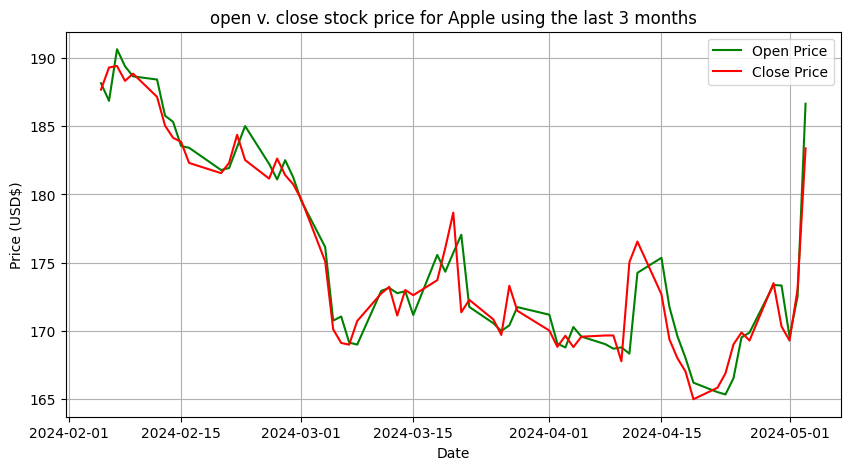

In [42]:
# Plot time series of open v. close stock price for Apple using the last 3 months of data
plt.figure(figsize=(10,5))
plt.plot(apple_last_3_months.index, apple_last_3_months['Open'], label='Open Price', color="green")
plt.plot(apple_last_3_months.index, apple_last_3_months['Close/Last'], label='Close Price', color="red")
plt.xlabel('Date')
plt.ylabel('Price (USD$)')
plt.title('open v. close stock price for Apple using the last 3 months')
plt.legend()
plt.grid()
plt.show()



## EDA: Plotting a histogram of a stock's closing price in the last three months

One way to see how much a stock's price generally moves is to plot the frequency of closing prices over a set time period. 

Your task:
* Use the **last three months** of Apple stock data and plot a histogram of closing price

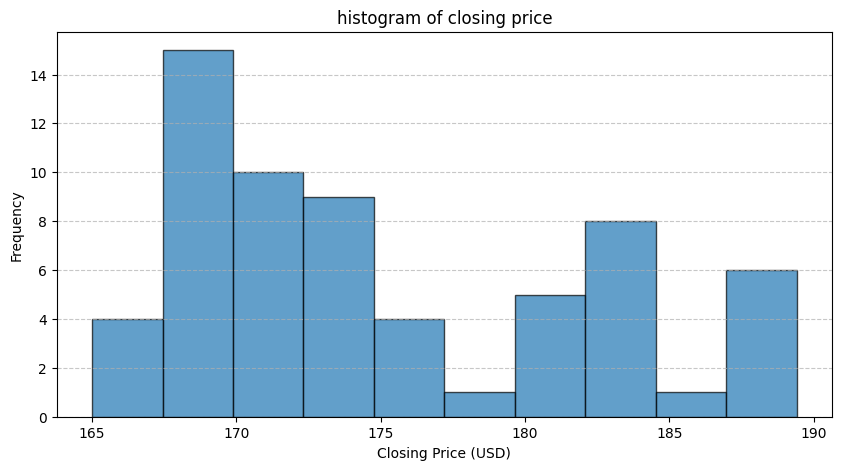

In [43]:
# Plot the histogram of Apple's closing price over the last 3 months 
plt.figure(figsize=(10, 5))
plt.hist(data = apple_last_3_months, x= 'Close/Last', edgecolor='black', alpha=0.7)
plt.xlabel("Closing Price (USD)")
plt.ylabel("Frequency")
plt.title("histogram of closing price")
plt.grid(axis='y', linestyle='--', alpha=0.7)


## Calculating correlation between a stock price and a macroeconomic variable 

Inflation affects the purchasing power of money and can influence corporate profits, interest rates, and consumer behavior. By analyzing the correlation between stock prices and inflation, one can gauge how inflationary trends impact stock market performance. For instance, high inflation might erode profit margins and reduce stock prices, while moderate inflation might indicate a growing economy, benefiting stocks.

Your task:
* Plot a heatmap that shows the correlation between Microsoft and Apple returns and inflation 

This will require several steps:
1. Calculate the returns for Apple and Microsoft and the change in monthly inflation (use the `pct_change` method for each)
2. Interpolate the daily stock returns data to monthly so it can be compared to the monthly inflation data
3. Merge the stock returns (Apple and Microsoft) and inflation data series into a single dataframe
4. Calculate the correlation matrix between the Apple returns, Microsoft returns, and inflation change
5. Plot the correlation matrix as a heatmap

### 1. Calculate returns for Microsoft / Apple and the monthly change in inflation

In [44]:
apple_df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2014-05-06,21.23,373872650,21.49,21.59,21.23
2014-05-07,21.15,282128727,21.26,21.33,20.99
2014-05-08,21.00,228973884,21.01,21.23,20.94
2014-05-09,20.91,291068564,20.88,20.94,20.73
2014-05-12,21.17,212736019,20.98,21.20,20.98


In [45]:
# Calculate daily returns for Apple and Microsoft and the percent change in inflation from month to month
rd_apple = apple_df.pct_change()
rd_microsoft = microsoft_df.pct_change()

In [46]:
rd_apple.isnull().sum()

Close/Last    1
Volume        1
Open          1
High          1
Low           1
dtype: int64

In [47]:
rd_apple = rd_apple.dropna()

In [48]:
rd_apple.isnull().sum()

Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [49]:
rd_microsoft.isnull().sum()

Close/Last    1
Volume        1
Open          1
High          1
Low           1
dtype: int64

In [50]:
rd_microsoft = rd_microsoft.dropna()
rd_microsoft.isnull().sum()

Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [51]:
rd_inflation = inflation_df.pct_change()

In [52]:
rd_inflation = rd_inflation.dropna()
rd_inflation.isnull().sum()

CORESTICKM159SFRBATL    0
dtype: int64

### 2. Interpolate stock returns from daily to monthly

In [53]:
rd_apple.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2014-05-07,-0.003768,-0.245388,-0.010703,-0.012043,-0.011305
2014-05-08,-0.007092,-0.188406,-0.011759,-0.004688,-0.002382
2014-05-09,-0.004286,0.271187,-0.006188,-0.013660,-0.010029
2014-05-12,0.012434,-0.269121,0.004789,0.012416,0.012060
2014-05-13,0.001889,-0.250630,0.007626,0.001415,0.005720


In [54]:
monthly_rd_apple = (1+rd_apple).resample('ME').prod()-1
monthly_rd_apple.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2014-05-31,0.065002,0.507038,0.060493,0.065771,0.057937
2014-06-30,0.027421,-0.648770,0.010531,0.018253,0.024933
2014-07-31,0.028842,0.144544,0.054711,0.039693,0.035187
2014-08-31,0.072385,-0.213849,0.058872,0.056240,0.072178
2014-09-30,-0.017167,0.238203,-0.020218,-0.013214,-0.016438


In [55]:
monthly_rd_microsoft = (1+rd_microsoft).resample('ME').prod()-1
monthly_rd_microsoft.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2014-05-31,0.048131,0.275170,0.029524,0.041169,0.033376
2014-06-30,0.018564,-0.109190,0.042522,0.030266,0.036025
2014-07-31,0.035012,0.023948,0.028693,0.035063,0.033094
2014-08-31,0.052595,-0.315587,0.039419,0.040055,0.041202
2014-09-30,0.020471,0.529192,0.028388,0.022806,0.025750


### 3. Merge the dataframes and calculate / plot the correlation

In [56]:
apple_close = monthly_rd_apple[['Close/Last']].rename(columns={"Close/Last": "AAPL"})
apple_close.head()

,AAPL
Date,
2014-05-31,0.065002
2014-06-30,0.027421
2014-07-31,0.028842
2014-08-31,0.072385
2014-09-30,-0.017167


In [57]:
microsoft_close = monthly_rd_microsoft[['Close/Last']].rename(columns={"Close/Last": "MSFT"})
microsoft_close.head()

,MSFT
Date,
2014-05-31,0.048131
2014-06-30,0.018564
2014-07-31,0.035012
2014-08-31,0.052595
2014-09-30,0.020471


In [58]:
rd_inflation = rd_inflation.rename(columns={"CORESTICKM159SFRBATL": "Inflation"})
rd_inflation.head()

,Inflation
DATE,
1968-02-29,0.006013
1968-03-31,0.127482
1968-04-30,0.003299
1968-05-31,-0.016262
1968-06-30,0.111863


In [59]:

merged_df = apple_close.merge(microsoft_close, left_index=True, right_index=True, how="inner").merge(rd_inflation, left_index=True, right_index=True, how="inner")
merged_df.head()

,AAPL,MSFT,Inflation
2014-05-31,0.065002,0.048131,0.050251
2014-06-30,0.027421,0.018564,0.007147
2014-07-31,0.028842,0.035012,-0.020724
2014-08-31,0.072385,0.052595,-0.066387
2014-09-30,-0.017167,0.020471,-0.004516


### 4. Calculate the correlation matrix between the Apple returns, Microsoft returns, and inflation change

In [60]:
# Calculate correlation matrix
correlation = merged_df.corr()
correlation

,AAPL,MSFT,Inflation
AAPL,1.000000,0.588237,-0.074699
MSFT,0.588237,1.000000,-0.070176
Inflation,-0.074699,-0.070176,1.000000


### 5. Plot the correlation matrix as a heatmap 

Text(0.5, 1.0, 'Correlation Between Apple, Microsoft and Inflation change')

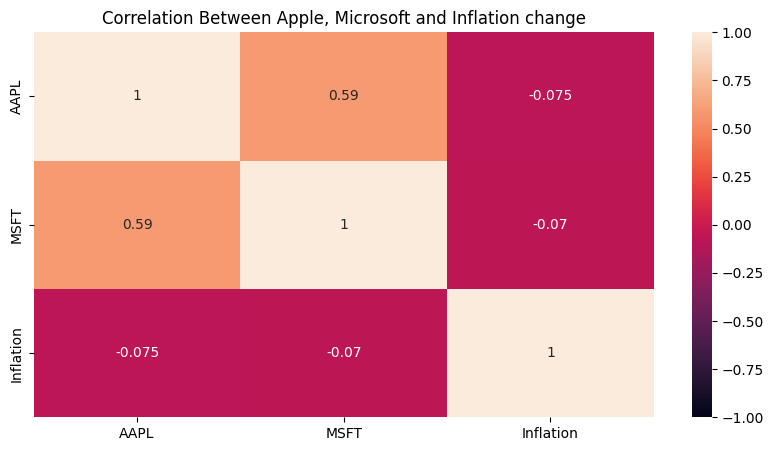

In [61]:
# Plot heatmap
plt.figure(figsize =(10,5))
sns.heatmap(correlation, annot = True,  vmin = -1,vmax = 1, )

plt.title("Correlation Between Apple, Microsoft and Inflation change")

## Calculating rolling volatility (standard deviation) of a stock's price for last 3 months

Volatility is a measure of the dispersion of returns for a given security. By calculating rolling volatility, investors can assess the risk associated with a stock over time: Higher volatility indicates higher risk, as the stock's price is more likely to experience significant fluctuations. In portfolio optimization, understanding the volatility of individual stocks and how it changes over time is crucial for diversification and optimization. By analyzing rolling volatility, investors can adjust their portfolios to maintain a desired risk level, potentially improving the risk-return profile.

One possible way to calculate volatility is by using the standard deviation of returns for a stock over time.

Your task:
* Calculate the weekly rolling standard deviation for Apple's closing price
* Plot the calculated rolling weekly volatility of Apple's closing price against Apple's closing price. Plot these **on the same chart, but using different y-axes**

Helpful hints:
* You'll need to use the `pandas` `rolling()` method with a given `window_size` parameter to make it a _weekly_ rolling calculation
* Use **only the last three months of data**; data much older than this may not be as useful for portfolio optimization
* You'll need to create two axes on the matplotlib figure to be able to use two different y-axes (one for the closing price and one for the rolling volatility calculated here)

In [62]:
# Define the window size for the rolling calculation (e.g., one week)
window_size=5

In [63]:
rd_apple

,Close/Last,Volume,Open,High,Low
Date,,,,,
2014-05-07,-0.003768,-0.245388,-0.010703,-0.012043,-0.011305
2014-05-08,-0.007092,-0.188406,-0.011759,-0.004688,-0.002382
2014-05-09,-0.004286,0.271187,-0.006188,-0.013660,-0.010029
2014-05-12,0.012434,-0.269121,0.004789,0.012416,0.012060
2014-05-13,0.001889,-0.250630,0.007626,0.001415,0.005720
...,...,...,...,...,...
2024-04-29,0.024808,0.520337,0.020544,0.027372,0.023171
2024-04-30,-0.018271,-0.032781,-0.000231,-0.005908,-0.017909
2024-05-01,-0.006047,-0.235864,-0.021635,-0.013029,-0.005235


In [64]:
apple_rd_last_3_months = rd_apple[rd_apple.index >= date]
apple_rd_last_3_months

,Close/Last,Volume,Open,High,Low
Date,,,,,
2024-02-05,0.009847,-0.320647,0.046091,0.010249,0.036764
2024-02-06,0.008632,-0.375750,-0.006856,0.000317,0.005004
2024-02-07,0.000581,0.228743,0.020229,0.009191,0.009852
2024-02-08,-0.005755,-0.233480,-0.006557,-0.007904,-0.006680
2024-02-09,0.002814,0.102367,-0.003907,0.002374,0.003469
...,...,...,...,...,...
2024-04-29,0.024808,0.520337,0.020544,0.027372,0.023171
2024-04-30,-0.018271,-0.032781,-0.000231,-0.005908,-0.017909
2024-05-01,-0.006047,-0.235864,-0.021635,-0.013029,-0.005235


In [65]:
# Calculate rolling one-week volatility
apple_last_3_months.loc[:, 'Rolling'] = (rd_apple["Close/Last"].rolling(window = window_size).std()).loc[rd_apple.index >= date]

In [66]:
apple_last_3_months

,Close/Last,Volume,Open,High,Low,Rolling
Date,,,,,,
2024-02-05,187.68,69668820,188.15,189.25,185.84,0.015513
2024-02-06,189.30,43490760,186.86,189.31,186.77,0.013633
2024-02-07,189.41,53438960,190.64,191.05,188.61,0.007636
2024-02-08,188.32,40962050,189.39,189.54,187.35,0.007444
2024-02-09,188.85,45155220,188.65,189.99,188.00,0.006342
...,...,...,...,...,...,...
2024-04-29,173.50,68169420,173.37,176.03,173.10,0.010497
2024-04-30,170.33,65934780,173.33,174.99,170.00,0.016292
2024-05-01,169.30,50383150,169.58,172.71,169.11,0.015996


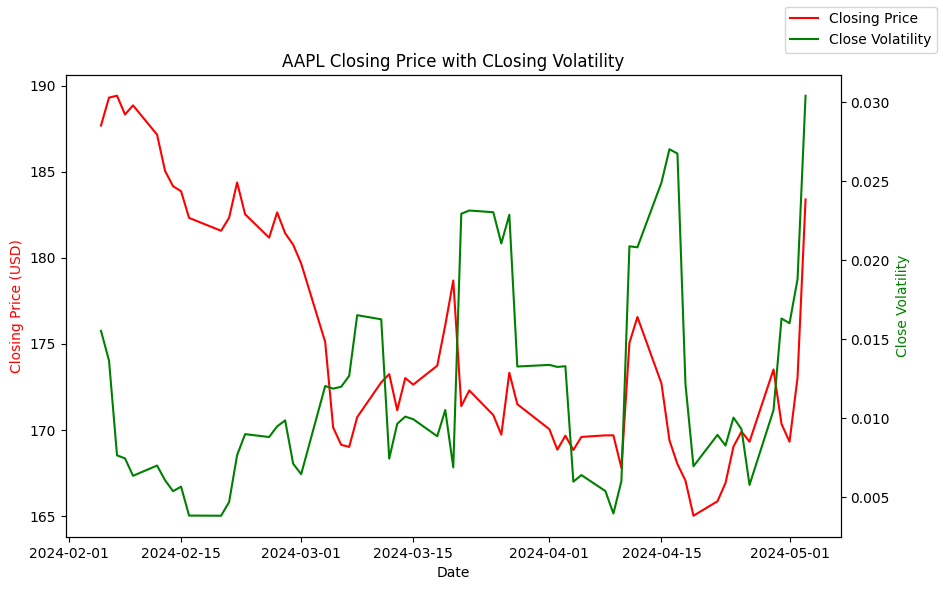

In [67]:
# Plot the calculated rolling weekly volatility of Apple's closing price against Apple's closing price
# Plot these on the same chart, but using different y-axes
fig, ax1 = plt.subplots( figsize=(10,6))


ax1.plot(apple_last_3_months.index, apple_last_3_months['Close/Last'], label='Closing Price', color='red')
ax1.set_xlabel("Date")
ax1.set_ylabel("Closing Price (USD)",color='red')

ax2 = ax1.twinx()
ax2.plot(apple_last_3_months.index, apple_last_3_months['Rolling'], label='Close Volatility', color='green')
ax2.set_ylabel("Close Volatility",color='green')

plt.title('AAPL Closing Price with CLosing Volatility')
fig.legend()


plt.show()


## Export data

Now that you have preprocessed your data, you should save it in new csv files so that it can be used in downstream tasks without having to redo all the preprocessing steps. 

Your task:
* Use `pandas` to export all modified datasets back to new CSV files

In [68]:
merged_df.to_csv("all_returns.csv")
rd_microsoft.to_csv("microsoft_returns.csv")
rd_apple.to_csv("apple_returns.csv")
rd_inflation.to_csv("inflation_returns.csv")
GDP_df.to_csv("GDP.csv")
apple_last_3_months.to_csv("apple_last_3_months_returns.csv")
inflation_weekly_data.to_csv("inflation_weekly_returns.csv")
inflation_quarter_data.to_csv("inflation_quarterly_returns.csv")
monthly_rd_apple.to_csv("apple_monthly_returns.csv")
monthly_rd_microsoft.to_csv("microsoft_monthly_returns.csv")